In [86]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal
from scipy.optimize import brentq
from matplotlib.ticker import FixedFormatter
from functions import quantizer, amplitude_sampler

import filters_func 

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
def test_func(x):
    f0 = 1.2 # Hz
    return 0.3 * np.sin(2 * np.pi * f0 * x) + 0.5 * np.sin(2 * np.pi * 2 * f0 * x) 

In [89]:
'''
def test_func(x):
    f0 = 2.5 # Hz
    return 0.3 * signal.sawtooth(2 * np.pi * f0 * x, 0.6)
'''

'\ndef test_func(x):\n    f0 = 2.5 # Hz\n    return 0.3 * signal.sawtooth(2 * np.pi * f0 * x, 0.6)\n'

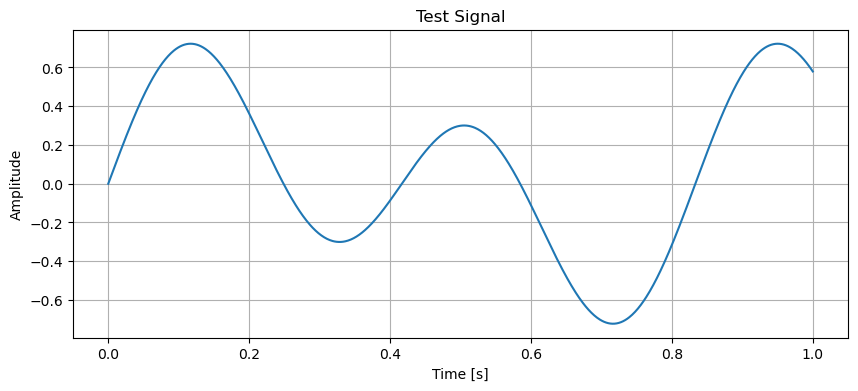

In [90]:
stop_time = 1
x= np.linspace(0, stop_time, 1000) #time vector 

plt.plot(x, test_func(x))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Test Signal')
plt.grid()

-0.3333333333333333


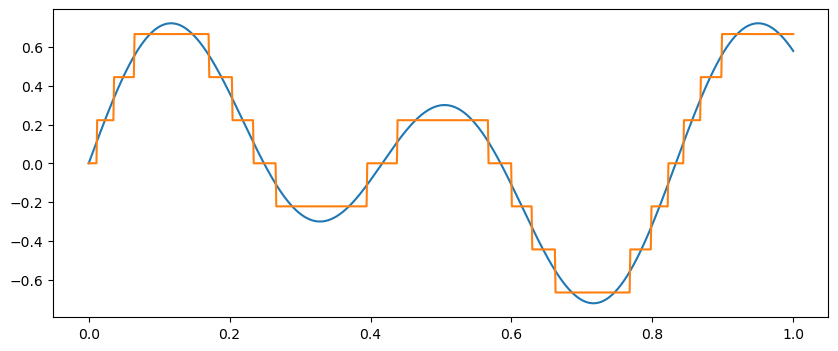

In [91]:
from functions import quantizer

q = quantizer(9)
step = q.step
print(q.qthreshold(2,3))

plt.rcParams["figure.figsize"] = (10,4)
plt.plot(x, test_func(x))
plt.plot(x, q.quantize(test_func(x)));



Transition instants: [0.         0.01138197 0.03537639 0.06484626 0.17091105 0.20388667
 0.2332678  0.26620047 0.39511597 0.43821736 0.56713287 0.60006553
 0.62944666 0.66242228 0.76848708 0.79795694 0.82195136 0.8447153
 0.86870973 0.89817959]
Bins index: [4 5 6 7 6 5 4 3 4 5 4 3 2 1 2 3 4 5 6 7]
Quantization values: [ 0.          0.22222222  0.44444444  0.66666667  0.44444444  0.22222222
  0.         -0.22222222  0.          0.22222222  0.         -0.22222222
 -0.44444444 -0.66666667 -0.44444444 -0.22222222  0.          0.22222222
  0.44444444  0.66666667]


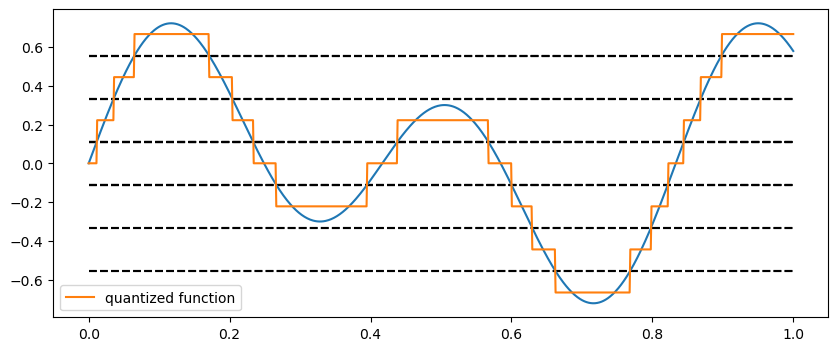

In [92]:
T = int(stop_time)

# transitions and bins
t, q_idx = amplitude_sampler(test_func, T, q)

# bins to quantization values
a = q.qvalue(q_idx)  #--> find the step y value for each bin 

print('Transition instants: {}'.format(t))
print('Bins index: {}'.format(q_idx))
print('Quantization values: {}'.format(a))

for i in range(0,len(q_idx)-1): 
    plt.hlines(q.qthreshold(q_idx[i],q_idx[i+1]), 0, 1,'black', linestyles='dashed', label='')

plt.plot(x, test_func(x));
plt.plot(x, q.quantize(test_func(x)), label='quantized function')
plt.legend()

In [93]:
Nqbits = 3; 

binary_idx = np.zeros(len(q_idx))
binary_list = []

def binary_encoding(bin_idx, Nqbits):
    for i in range(0,len(binary_idx)):
        # Convert to binary string, removing the '0b' prefix
        # Fill with zeros to have a fixed length of Nqbits

        binary_str = bin(bin_idx[i])[2:].zfill(Nqbits) 
        binary_list.append(binary_str)

def bit_extract(bi_list, idx):
    return  [bits[idx] for bits in bi_list]



binary_encoding(q_idx, Nqbits)

print('Bins index: {}'.format(q_idx))
print('Binary encoding: {}'.format(binary_list))
print('Least significant bit: {}'.format(bit_extract(binary_list, -1)))
print('Most significant bit (for 3 qbits): {}'.format(bit_extract(binary_list, 0)))
print('Middle bit (for 3 qbits): {}'.format(bit_extract(binary_list, 1)))


Bins index: [4 5 6 7 6 5 4 3 4 5 4 3 2 1 2 3 4 5 6 7]
Binary encoding: ['100', '101', '110', '111', '110', '101', '100', '011', '100', '101', '100', '011', '010', '001', '010', '011', '100', '101', '110', '111']
Least significant bit: ['0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1']
Most significant bit (for 3 qbits): ['1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1']
Middle bit (for 3 qbits): ['0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1']


In [94]:
msb = [int(b) for b in bit_extract(binary_list, 0)]
lsb = [int(b) for b in bit_extract(binary_list, -1)]
middle = [int(b) for b in bit_extract(binary_list, 1)]

In [95]:
t_round = np.round(t, 3)
t_round = np.append(t_round, 1)
t_range = np.arange(0, 1 + 0.001, 0.001, dtype=float)

lsb_plot = np.zeros(len(t_range))
msb_plot = np.zeros(len(t_range))
middle_plot = np.zeros(len(t_range))


for i in range(len(lsb)):
    if lsb[i] == 1:
        lsb_plot[int(t_round[i]*1000) : int(t_round[i+1]*1000)] = 1
    if msb[i] == 1: 
        msb_plot[int(t_round[i]*1000) : int(t_round[i+1]*1000)] = 1
    if middle[i] == 1: 
        middle_plot[int(t_round[i]*1000) : int(t_round[i+1]*1000)] = 1


In [96]:
bit_waves = np.vstack([msb_plot,  middle_plot, lsb_plot])

Text(0.5, 1.0, 'Binary encoding of the quantized signal')

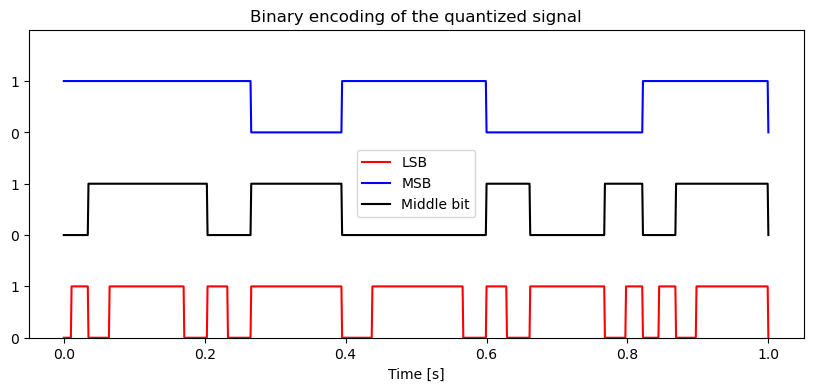

In [97]:
plt.plot(t_range, lsb_plot, 'red', label='LSB')
plt.plot(t_range, msb_plot+4, 'b', label='MSB')
plt.plot(t_range, middle_plot+2, 'black', label='Middle bit')
y_tick_labels = ['0', '1', '0', '1', '0', '1']
plt.yticks([0,1,2,3,4,5], y_tick_labels)
plt.legend()
plt.xlabel('Time [s]')
plt.ylim(0,6)
plt.title('Binary encoding of the quantized signal')



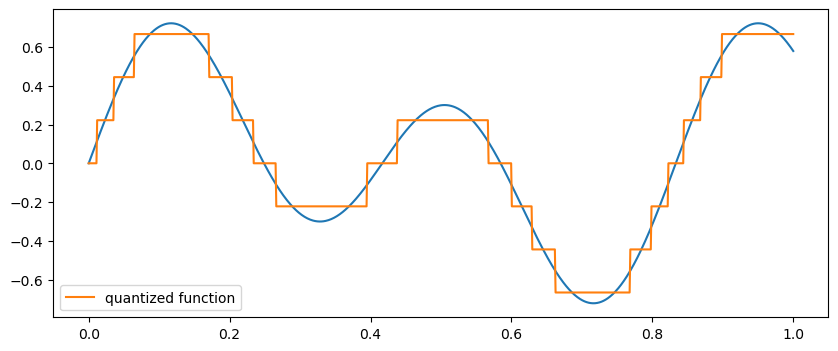

In [98]:
plt.plot(x, test_func(x));
plt.plot(x, q.quantize(test_func(x)), label='quantized function')
plt.legend()

In [ ]:
q_tot = 0
for i in range(1,np.shape(bit_waves)[0]+1):

    q_temp = 2**(-i)*bit_waves[i-1,:]
    q_tot = q_tot + q_temp

plt.plot(t_range[:-1], q_tot[:-1])

onda triangolare + skew rate 

## FIR filter design 

In [ ]:
import filters_func 
from filters_func import perform  
 

In [ ]:
filter_list = ['Moving average','Moving average_weight', 'Hamming window', 'Bartlet triangular', 'Butterworth', 'Low-pass']

### Moving average 
- the tap weights are all equal to 1/N
- each output sample is the average of the previous N input samples

In [ ]:
# moving average filter coefficients

def MA_filter(x, M, q_sig, delay ):
    
    y=np.zeros(len(x)-1)
    
    for k in range(1,M):
        a_k = (1/M)
        q_delay=np.concatenate((np.zeros(delay*k-1), q_sig[:-k*delay]))
   
        y = y + a_k*q_delay  
    return y

def WMA_filter(x, M, q_sig, delay ):
    y=np.zeros(len(x)-1)
    for k in range(1,M):
        a_k = (1/(k*(i+1)))
        q_delay=np.concatenate((np.zeros(delay*k), q_sig[:-k*delay]))
   
        y = y + a_k*q_delay  
    return y

In [ ]:
K = 10
delay = 10

In [ ]:
from filters_func import FIR_class
f = FIR_class(K, delay)

import importlib
importlib.reload(filters_func)
y_ma_class= f.movingAvg(x, q_tot, corr=1)



In [ ]:
plt.plot(x, y_ma_class, label='Simple moving average')
plt.plot(x, test_func(x),  label='Original signal')
#plt.plot(x[:-1], y_wma, label='Weighted moving average')
plt.title('Simple moving average FIR ')
plt.legend()

In [ ]:
# delay taps at the beginning ? 

K = 10
delay = 10
q_test = q.quantize(test_func(x))
y_ma = MA_filter(x, K, q_test, delay)

plt.plot(x, y_ma, label='Simple moving average')
plt.plot(x, test_func(x),  label='Original signal')
#plt.plot(x[:-1], y_wma, label='Weighted moving average')
plt.title('Simple moving average FIR ')
plt.legend()

perform(y_ma, test_func(x), filter_list[0])

### Hamming window filter


In [ ]:
y_ham = f.hamming(x, q_tot, corr=0.22)

In [ ]:
def hamming(x, M, q_sig, delay ):
    y=np.zeros(len(x)-1)
    for k in range(1,M):
        a_k =( 0.54 - 0.46 * np.cos((2*np.pi*k)/(M-1)))*0.22
        q_delay=np.concatenate((np.zeros(delay*k-1), q_sig[:-k*delay]))
   
        y = y + a_k*q_delay  
    return y

K = 10
delay = 12
corr = 0.22

q_test = q.quantize(test_func(x))
y_ham = hamming(x, K, q_test, delay)

plt.plot(x[:-1-16], y_ham[16:], label='Hamming window filter')
plt.plot(x, test_func(x),  label='Original signal')
plt.title('Simple moving average FIR ')
plt.legend()

perform(y_ham, test_func(x)[:-1], filter_list[2])

### Bartlet triangular filter 

In [ ]:
def bartlett_triang(x, M, q_sig, delay ):
    y=np.zeros(len(x)-1)
    for k in range(1,M):
        a_k = ( (2/M) * ((M-1)/2 - abs((M-1)/2 - k)) )*0.25
        q_delay=np.concatenate((np.zeros(delay*k-1), q_sig[:-k*delay]))
   
        y = y + a_k*q_delay  
    return y

In [ ]:
K = 10
delay = 12

corr = 0.25

q_test = q.quantize(test_func(x))
y_b = bartlett_triang(x, K, q_test, delay)

plt.plot(x[:-1-16], y_b[16:], label='Bartlett triangular')
plt.plot(x, test_func(x),  label='Original signal')
plt.title('Simple moving average FIR ')
plt.legend()

perform(y_b, test_func(x)[:-1], filter_list[3])

### Butterworth filter

In [ ]:
import numpy as np
from scipy.signal import butter,filtfilt

def butter_lowpass_filter(data, cutoff, fs, order, nyq):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    print(len(b)), print(len(a))
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Filter requirements.        
fs_b = 500.0
T_b = 1/fs_b       # sample rate, Hz
cutoff = 2.5    # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs_b  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T_b * fs_b) # total number of samples

In [ ]:
# Filter the data, and plot both the original and filtered signal

import plotly.graph_objects as go 
import plotly.express as px

y = butter_lowpass_filter(q_test, cutoff, fs_b, order)

plt.plot(x, test_func(x), label='original function')
plt.plot(x, y, label='filtered qunatized signal')
plt.title('Butterworth filter')
plt.legend()
plt.grid()
plt.show()


'''
fig.add_trace(go.Scatter(
            y = q_test,
            line =  dict(shape =  'spline' ),
            name = 'signal with noise'
            ))
fig.add_trace(go.Scatter(
            y = y,
            line =  dict(shape =  'spline' ),
            name = 'filtered signal'
            ))
fig.show()
'''

perform(y, test_func(x), filter_list[4])

### Simple low-pass 

In [ ]:
def low_pass_fir(signal, cutoff_freq, num_taps, f_smp):
    # Normalize cutoff frequency
    normalized_cutoff = cutoff_freq / (0.5 * f_smp)

    # Compute filter coefficients using the windowing method
    coefficients = np.sinc(2 * normalized_cutoff * (np.arange(num_taps) - (num_taps - 1) / 2))*0.025
    window = np.hamming(num_taps)
    coefficients = coefficients * window

    # Apply the filter to the signal using convolution
    filtered_signal = np.convolve(signal, coefficients, mode='same')

    return filtered_signal

In [ ]:
y_lp = low_pass_fir(q_test, cutoff, 130, fs_b)

plt.plot(x, test_func(x), label='original function')
plt.plot(x, y_lp, label='Low pass filter')
plt.title('Low pass filter')
plt.legend()
plt.grid()

perform(y_lp, test_func(x), filter_list[5])